## Model Development

Melakukan import library yang dibutuhkan

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import adjustText
import tensorflow_hub as hub
import seaborn as sns

Melakukan import dataset

In [2]:
df_data = pd.read_csv('../Data/data_2/clean_review_small.csv')
df_data

,text,label
0,believe hope thing usually enjoy merritt usual...,negative
1,get bed bag hotel stay night location good que...,negative
2,ok stay family point easy get we dirty conveni...,negative
3,charge business facility service terrible room...,negative
4,hate stay homestead suite stay blotched reserv...,negative
...,...,...
143565,great hotel service stay hotel end june catch ...,positive
143566,would stay anywhere else carlyle suites hotel ...,positive
143567,love get back spend lodge street location exce...,positive
143568,highly recommend hotel anyone stay hotel day e...,positive


### TF-IDF Method

TFIDF pada studi kasus ini digunakan untuk menampilkan kata-kata yang paling unique pada masing-masing sentimen.

In [3]:
negative_reviews = df_data[df_data['label'] == 'negative']['text']
positive_reviews = df_data[df_data['label'] == 'positive']['text']
neutral_reviews = df_data[df_data['label'] == 'neutral']['text']


all_reviews = df_data['text']

vectorizer = TfidfVectorizer(max_features = 1000, 
                                stop_words = 'english', 
                                max_df=0.5,
                                use_idf = True, 
                                smooth_idf = True, 
                                norm = 'l2')
tfidf_all = vectorizer.fit_transform(all_reviews)

tfidf_negative = vectorizer.transform(negative_reviews)
tfidf_positive = vectorizer.transform(positive_reviews)
tfidf_neutral = vectorizer.transform(neutral_reviews)

top_words_negative = {word: score for word, score in zip(vectorizer.get_feature_names_out(), np.max(tfidf_negative.toarray(), axis=0))} 
top_words_positive = {word: score for word, score in zip(vectorizer.get_feature_names_out(), np.max(tfidf_positive.toarray(), axis=0))}
top_words_neutral = {word: score for word, score in zip(vectorizer.get_feature_names_out(), np.max(tfidf_neutral.toarray(), axis=0))}

wordcloud_negative = WordCloud(max_font_size = 160, margin=0, background_color = "white").generate_from_frequencies(top_words_negative)
wordcloud_positive = WordCloud(max_font_size = 160, margin=0, background_color = "white").generate_from_frequencies(top_words_positive)
wordcloud_neutral = WordCloud(max_font_size = 160, margin=0, background_color = "white").generate_from_frequencies(top_words_neutral)

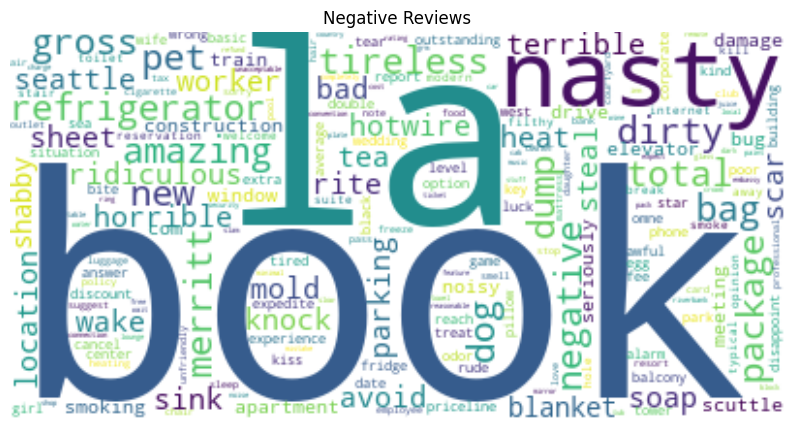

In [4]:
plt.figure(figsize=[10,10])
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Negative Reviews')
plt.axis("off")
plt.show()


Dari wordcloud yang dihasilkan, kita bisa melihat kata-kata yang unique pada negatif sentiment seperti "bug", "bedbug", "terrible", dll.

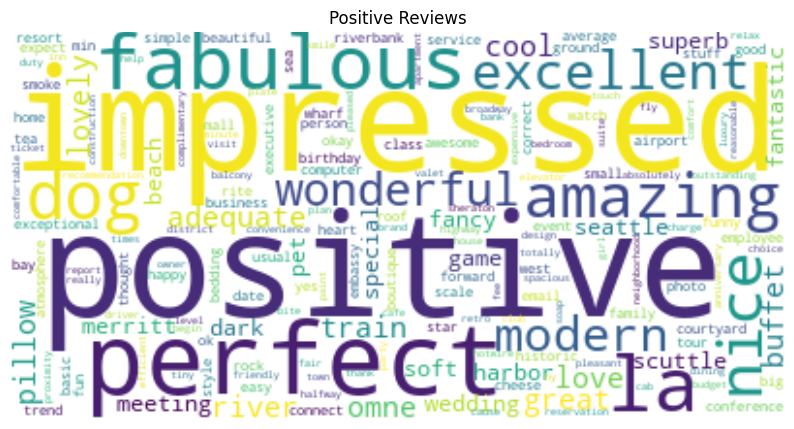

In [5]:
plt.figure(figsize=[10,10])
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Positive Reviews')
plt.axis("off")
plt.show()


Dari wordcloud yang dihasilkan, kita bisa melihat kata-kata yang unique pada positif sentiment seperti "cool", "great", "excellent", dll.

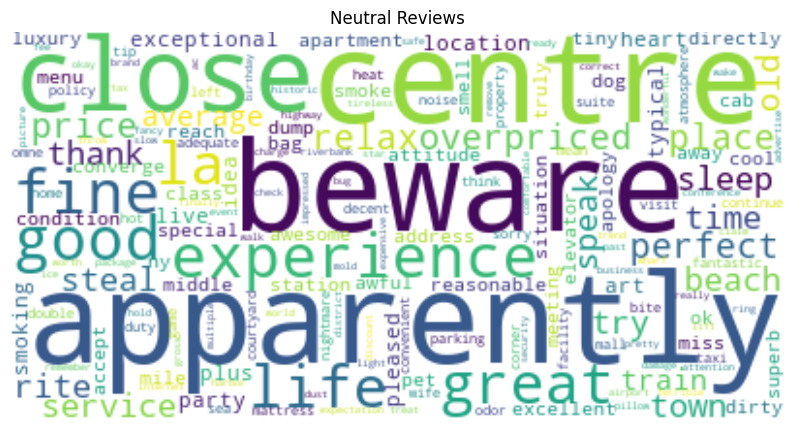

In [6]:
plt.figure(figsize=[10,10])
plt.imshow(wordcloud_neutral, interpolation='bilinear')
plt.title('Neutral Reviews')
plt.axis("off")
plt.show()

Dari wordcloud yang dihasilkan, kita bisa melihat kata-kata yang unique pada netral sentiment seperti "comfortabel", dll.

### Neural Network Method

Langkah pertama adalah yaitu melakukan encoding pada label sentiment.

In [7]:
encoding_5label = {
    'positive': 0,
    'neutral': 1,
    'negative': 2
}


In [8]:
df_data['label'] = df_data['label'].map(encoding_5label)
df_data

,text,label
0,believe hope thing usually enjoy merritt usual...,2
1,get bed bag hotel stay night location good que...,2
2,ok stay family point easy get we dirty conveni...,2
3,charge business facility service terrible room...,2
4,hate stay homestead suite stay blotched reserv...,2
...,...,...
143565,great hotel service stay hotel end june catch ...,0
143566,would stay anywhere else carlyle suites hotel ...,0
143567,love get back spend lodge street location exce...,0
143568,highly recommend hotel anyone stay hotel day e...,0


Setelah itu akan dilakukan split data menjadi train, test, dan validation dengan rasio 80:10:10. Rasio ini ditentukan berdasarkan ukuran dataset yang cukup besar.

In [9]:
x_train, x_test, y_train, y_test = train_test_split(df_data['text'], df_data['label'], test_size=0.2, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape, x_val.shape, y_val.shape

((114856,), (14357,), (114856,), (14357,), (14357,), (14357,))

In [10]:
tokenizer = Tokenizer(oov_token='<OOV>')

In [11]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=3)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=3)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=3)

Karena akan menggunakan pretrained model dari tensorflow, untuk itu harus dilakukan konversi data menjadi format tensor

In [12]:
x_train_tensor = tf.convert_to_tensor(x_train)
y_train_tensor = tf.convert_to_tensor(y_train)
x_test_tensor = tf.convert_to_tensor(x_test)
y_test_tensor = tf.convert_to_tensor(y_test)
x_val_tensor = tf.convert_to_tensor(x_val)
y_val_tensor = tf.convert_to_tensor(y_val)

Selanjutnya akan dilakukan trainning model dengan memanfaatkan pretrained model dari tensorflow. Hal ini dilakukan karena dataset yang digunakan cukup besar dan memerlukan waktu yang sangat lama untuk trainning model dari awal, sehingga memanfaatkan pretrained model akan mempercepat proses trainning model.

In [13]:
embedding = "https://tfhub.dev/google/nnlm-en-dim128/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)

model = tf.keras.Sequential([
    hub_layer,
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 128)               124642688 
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 124,651,139
Trainable params: 124,651,139
Non-trainable params: 0
_________________________________________________________________


In [14]:
history = model.fit(x_train_tensor, y_train_tensor, epochs=20, batch_size=128, validation_data=(x_test_tensor, y_test_tensor))

Epoch 1/20
898/898 [==============================] - 1496s 2s/step - loss: 0.7070 - accuracy: 0.6971 - val_loss: 0.6002 - val_accuracy: 0.7447
Epoch 2/20
898/898 [==============================] - 1487s 2s/step - loss: 0.5822 - accuracy: 0.7537 - val_loss: 0.5809 - val_accuracy: 0.7461
Epoch 3/20
898/898 [==============================] - 1436s 2s/step - loss: 0.5469 - accuracy: 0.7683 - val_loss: 0.5825 - val_accuracy: 0.7437
Epoch 4/20
898/898 [==============================] - 1354s 2s/step - loss: 0.5230 - accuracy: 0.7785 - val_loss: 0.5897 - val_accuracy: 0.7383
Epoch 5/20
898/898 [==============================] - 1324s 1s/step - loss: 0.5010 - accuracy: 0.7872 - val_loss: 0.6057 - val_accuracy: 0.7381
Epoch 6/20
898/898 [==============================] - 1325s 1s/step - loss: 0.4824 - accuracy: 0.7948 - val_loss: 0.6248 - val_accuracy: 0.7355
Epoch 7/20
898/898 [==============================] - 1344s 1s/step - loss: 0.4633 - accuracy: 0.8025 - val_loss: 0.6514 - val_accuracy:

Setelah dilakukan trainning model, akan dilakukan evaluasi model dengan menggunakan data validation.

In [ ]:
val_loss, val_accuracy = model.evaluate(x_val_tensor, y_val_tensor)

117/117 [==============================] - 0s 2ms/step - loss: 0.7905 - accuracy: 0.6380


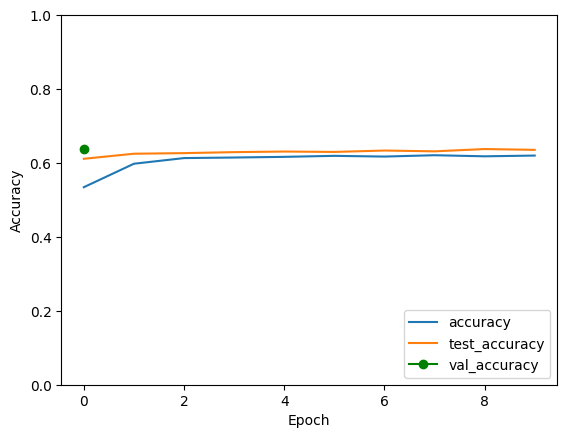

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='test_accuracy')
plt.plot(val_accuracy, label='val_accuracy',marker='o', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

Dari plot yang dihasilkan, kita bisa melihat bahwa model yang dibuat sudah cukup baik dalam memprediksi sentiment dari review yang diberikan, tidak terjadi overfitting dan underfitting.

Tahap selanjutnya yaitu melakukan evaluasi metric dalam studi kasus ini menggunakan confusion matrix

In [ ]:
predictions = model.predict(x_val_tensor)
predictions = np.argmax(predictions, axis=1)
conf_matrix = confusion_matrix(y_val, predictions)

117/117 [==============================] - 0s 3ms/step


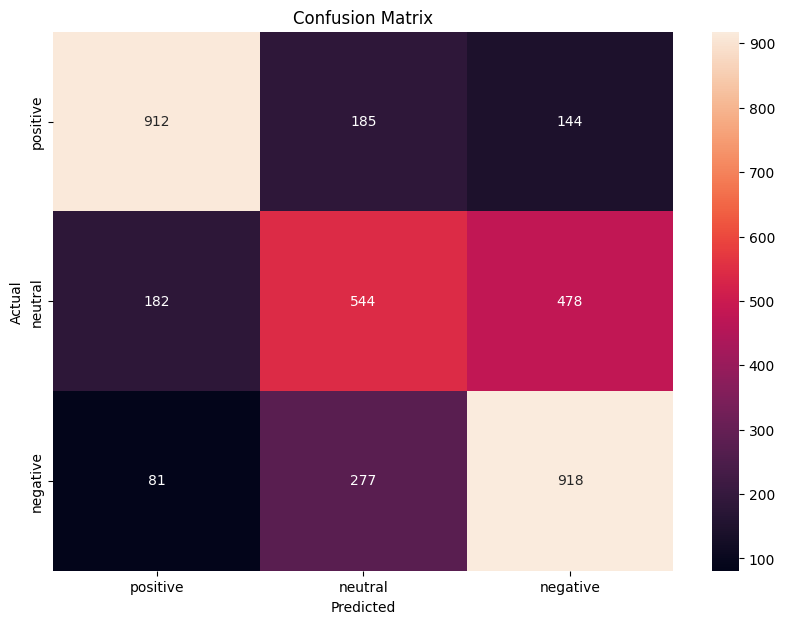

In [ ]:
df_confusion_matrix = pd.DataFrame(conf_matrix, index = ['positive', 'neutral', 'negative'], columns = ['positive', 'neutral', 'negative'])
plt.figure(figsize=(10,7))
plt.title('Confusion Matrix')
sns.heatmap(df_confusion_matrix, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Dari confusion matrix yang dihasilkan, pada label neutral terlihat beberapa data yang salah diprediksi sebagai label negatif dan positif. Hal ini bisa terjadi karena kata-kata yang digunakan pada review netral bisa saja mirip dengan kata-kata yang digunakan pada review negatif atau positif, begitu juga sebaliknya. Hal ini menunjukkan terdapat data yang beririsan antara label negatif, positif, dan netral, sehingga harus dilakukan preprocessing lebih lanjut untuk menangani hal ini.

In [ ]:
texts = df_data['text']

tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

word_index = tokenizer.word_index
embeddings = model.layers[0].get_weights()[0]
pca = PCA(n_components=10, random_state=42).fit_transform(embeddings)
embeddings_2d = TSNE(n_components=2, random_state=42, perplexity=35).fit_transform(pca)


magnitudes = np.linalg.norm(embeddings, axis=1)
top_indices = magnitudes.argsort()[-200:]
top_words = {word: index for word, index in word_index.items() if index in top_indices}

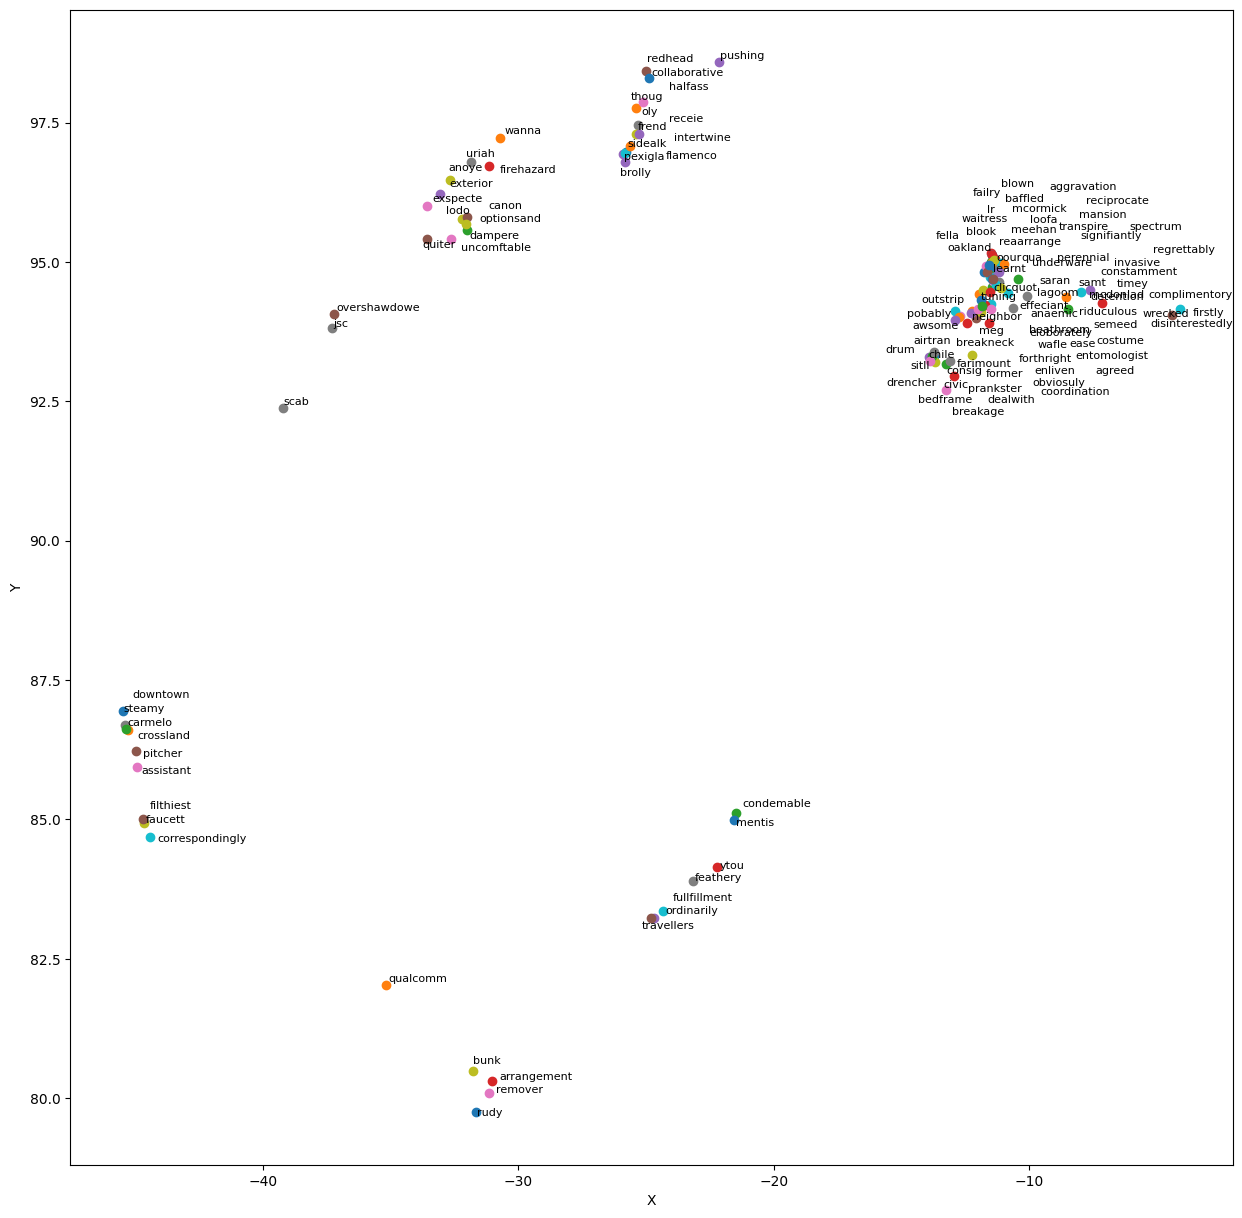

In [ ]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111)

for word, index in top_words.items():
    x, y = embeddings_2d[index]
    ax.scatter(x, y)
    ax.text(x, y, word, fontsize=8)

ax.set_xlabel('X')
ax.set_ylabel('Y')
adjustText.adjust_text(ax.texts,iterations=100)

plt.show()

In [ ]:
model.save('model_2.h5')